# Fitting Mass Functions with `emcee`

In this demo, we provide a very simple example of how to fit mass functions with `emcee`. This example does not do anything with the complexity required for fitting real-world data. It does not account for measurement error or Eddington bias. However, it gives a taste of what is achievable.

In [87]:
import emcee
import hmf
import numpy as np

import matplotlib.pyplot as plt
from scipy.stats import poisson
from multiprocessing import Pool



from IPython.display import display, Markdown

%matplotlib inline

In [2]:
emcee.__version__

'3.0.2'

In [3]:
hmf.__version__

'3.1.3.dev4+ge4212c6.d20200721'

## Create Some Mock Data

First, let's create a default model mass function:

In [43]:
model = hmf.MassFunction(z=1.5, transfer_model='EH')

Now, let's create some mock data, based on the true mass function, but with some randomness assuming the mass function was measured (perfectly) in some volume:

In [44]:
volume = 100 ** 3 # Mpc^3 / h^3

In [45]:
counts_per_bin = np.random.poisson(model.dndlog10m * volume * model.dlog10m)

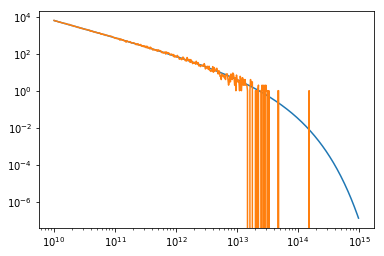

In [46]:
plt.plot(model.m, model.dndlog10m * volume * model.dlog10m)
plt.plot(model.m, counts_per_bin)
plt.xscale('log')
plt.yscale('log')

## Define a likelihood

Now let's define a likelihood function, based on some input model for `dndlog10m`. The model is simply a Poisson model. We take the model into the space in which it describes an actual number of observations, and get the log pdf there:

In [47]:
def log_likelihood(model, data, volume, dlog10m):
    return np.sum(poisson.logpmf(data, mu=model*volume*dlog10m))

## Define an `emcee`-compatible likelihood function

Now we define a likelihood function for `emcee`. There is a bit more flexibility here, as this function needs to calculate priors on all input parameters, and handle exceptions as well. This means this function is rather specific to the problem at hand. We will define a very simple function, but one that is fairly general.

In [48]:
fiducial_model = model.clone()

First, we define a small utility function that will take a dictionary in which keys may be dot-paths, and converts it to a nested dictionary:

In [49]:
def flat_to_nested_dict(dct: dict) -> dict:
    """Convert a dct of key: value pairs into a nested dict.
    
    Keys that have dots in them indicate nested structure.
    """    
    def key_to_dct(key, val, dct):
        if '.' in key:
            key, parts = key.split('.', maxsplit=1)
            
            if key not in dct:
                dct[key] = {}
                
            key_to_dct(parts, val, dct[key])
        else:
            dct[key] = val
            
    out = {} 
    for k, v in dct.items():
        key_to_dct(k, v, out)

    return out

So, this will do the following:

In [50]:
flat_to_nested_dict(
    {
        'nested.key': 1,
        'nested.key2': 2,
        'non_nested': 3
        
    }
)

{'nested': {'key': 1, 'key2': 2}, 'non_nested': 3}

This will enable us to pass a list of parameter names that we want updated, which could be parameters of nested models. This means our posterior function is fairly general, and can accept any model parameters to be updated:

In [98]:
def log_prob(param_values, param_names, data, model, volume, derived=None):
    # Update the base model with all the parameters that are being constrained.
    params = flat_to_nested_dict(dict(zip(param_names, param_values)))

    model.update(**params)
    
    if derived is not None:
        derived = [getattr(model, d) for d in derived]
    else:
        derived = []
        
    return log_likelihood(model.dndlog10m, data, volume, model.dlog10m), derived

We can test that the `log_prob` function works:

In [52]:
log_prob([0.9], ['sigma_8'], counts_per_bin, model, volume, derived=['mass_nonlinear'])

(-1390.6879386397318, [array(5.83204315e+10)])

Notice the derived parameters: we can pass any `quantity` of the `MassFunction`, and it will be stored on every iteration. Nice!

## Run `emcee`

Let's first run a simple model in which we just want to fit $\sigma_8$ and the spectral index $n_s$. We use the popular `emcee` package, and pass in our `log_prob` model:

In [60]:
sampler = emcee.EnsembleSampler(
    nwalkers = 100,
    ndim = 2,
    log_prob_fn = log_prob,
    kwargs = {
        'param_names': ['sigma_8', 'n'], 
        'data': counts_per_bin, 
        'model': model, 
        'volume': volume, 
        'derived': ['mass_nonlinear']
    },
    pool = Pool(4),
)

/home/steven/Documents/Projects/halos/HMF/hmf/src/hmf/mass_function/hmf.py:377: UserWarning: Nonlinear mass outside mass range
  warnings.warn("Nonlinear mass outside mass range")
/home/steven/Documents/Projects/halos/HMF/hmf/src/hmf/mass_function/hmf.py:377: UserWarning: Nonlinear mass outside mass range
  warnings.warn("Nonlinear mass outside mass range")
/home/steven/Documents/Projects/halos/HMF/hmf/src/hmf/mass_function/hmf.py:377: UserWarning: Nonlinear mass outside mass range
  warnings.warn("Nonlinear mass outside mass range")


On the advice of the `emcee` documentation, we set up some initial positions of the walkers around the solution.

In [61]:
initialpos = np.array([fiducial_model.sigma_8, fiducial_model.n]) + 1e-4 * np.random.normal(size=(sampler.nwalkers, sampler.ndim))

In [62]:
sampler.run_mcmc(initialpos, nsteps=1000)

State([[0.812517   0.96740204]
 [0.82984608 0.96694073]
 [0.81653361 0.9656326 ]
 [0.82261185 0.9665801 ]
 [0.8102518  0.96749993]
 [0.82020062 0.96884229]
 [0.81968681 0.96613499]
 [0.80751869 0.96396036]
 [0.81132914 0.96522728]
 [0.81345488 0.96482091]
 [0.81815306 0.96822774]
 [0.82297313 0.96462598]
 [0.82597001 0.96222415]
 [0.8204828  0.96716804]
 [0.82306268 0.96922072]
 [0.82241968 0.96456152]
 [0.82463299 0.9655332 ]
 [0.82045326 0.96579144]
 [0.81639143 0.96658896]
 [0.82310428 0.9682027 ]
 [0.82192434 0.96464978]
 [0.83147352 0.96654571]
 [0.8157654  0.96777175]
 [0.83319911 0.96809932]
 [0.81681679 0.9635151 ]
 [0.82759967 0.96613953]
 [0.82531001 0.96399171]
 [0.82192877 0.96582809]
 [0.81542795 0.9673587 ]
 [0.81230205 0.96544857]
 [0.81980445 0.96677717]
 [0.82473735 0.9661013 ]
 [0.83556881 0.96525546]
 [0.8145986  0.96269262]
 [0.81476969 0.96651966]
 [0.82230772 0.96429339]
 [0.82630066 0.96775328]
 [0.8170044  0.9620626 ]
 [0.81458535 0.96246315]
 [0.81471739 0.9662

Now we can plot the posterior as a heatmap, with the true input values shown as white lines:

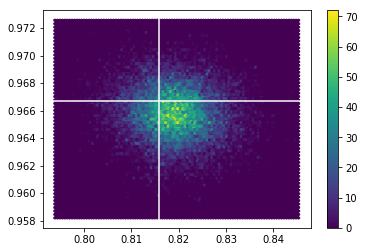

In [78]:
plt.hexbin(sampler.chain[:,500:, 0].flatten(), sampler.chain[:,500:, 1].flatten())
plt.axvline(fiducial_model.sigma_8, color='white')
plt.axhline(fiducial_model.n, color='white')
plt.colorbar()

And we're done! The posterior contains the truth to within 1-sigma, and we have ~1% error-bars on $\sigma_8$ and ~0.2% error-bars on $n$.

## An example of fitting a new fitting function

Perhaps you are a simulator and want to deliver a new fitting function, or at least new parameters for a particular fitting function. Let's look at an example of this. We choose the Sheth-Tormen function:

In [94]:
fiducial_model = hmf.MassFunction(z=0, hmf_model='SMT', dlog10m=0.2, Mmin=10, Mmax=16)

The functional form of $f(\nu)$ is:

In [91]:
display(Markdown(f"${fiducial_model.hmf._eq}$"))

$A\sqrt{2a/\pi}\nu\exp(-a\nu^2/2)(1+(a\nu^2)^{-p})$

The fitted parameters are:

In [92]:
fiducial_model.hmf.params

{'a': 0.707, 'p': 0.3, 'A': 0.3222}

Again, we use a Poisson model to create mock data, this time in a Gpc volume:

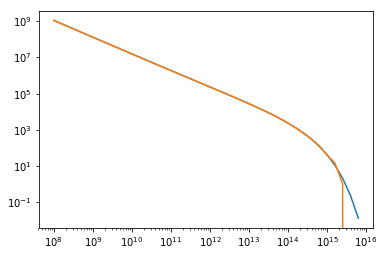

In [95]:
volume = 500 ** 3 # Mpc^3 / h^3

counts_per_bin = np.random.poisson(fiducial_model.dndlog10m * volume * fiducial_model.dlog10m)

plt.plot(fiducial_model.m, fiducial_model.dndlog10m * volume * fiducial_model.dlog10m)
plt.plot(fiducial_model.m, counts_per_bin)
plt.xscale('log')
plt.yscale('log')

We've already set up our probability function, which was already general enough to be able to fit the hmf parameters, so off we go!

In [96]:
smt_model = fiducial_model.clone()

In [99]:
sampler_hmf = emcee.EnsembleSampler(
    nwalkers = 50,
    ndim = 3,
    log_prob_fn = log_prob,
    kwargs = {
        'param_names': ['hmf_params.a', 'hmf_params.p', 'hmf_params.A'], 
        'data': counts_per_bin, 
        'model': smt_model, 
        'volume': volume, 
        'derived': ['dndlog10m']
    },
    pool = Pool(4),
)

In [100]:
init_pos = (
    np.array([
        smt_model.hmf.params['a'], 
        smt_model.hmf.params['p'], 
        smt_model.hmf.params['A']]) + 
    1e-4 * np.random.normal(size=(sampler_hmf.nwalkers, sampler_hmf.ndim))
)

In [103]:
sampler_hmf.run_mcmc(init_pos, nsteps=300, progress='notebook')

State([[0.70571872 0.30004471 0.32231539]
 [0.70126824 0.30036688 0.32263641]
 [0.70542706 0.30004243 0.32235664]
 [0.70898865 0.30002223 0.32194784]
 [0.70514584 0.30010418 0.32234736]
 [0.70760904 0.30015674 0.32201378]
 [0.70865575 0.29998153 0.32200619]
 [0.70629783 0.29995717 0.32231429]
 [0.70670178 0.30012446 0.32214238]
 [0.70399317 0.30004328 0.32251483]
 [0.71196335 0.29985674 0.32170366]
 [0.71287314 0.29977231 0.32165765]
 [0.70657605 0.30000788 0.322248  ]
 [0.70154182 0.30031702 0.32263111]
 [0.70613473 0.30017031 0.32218223]
 [0.69897046 0.30028188 0.32297026]
 [0.71286506 0.2998973  0.3215743 ]
 [0.70397023 0.30011033 0.322486  ]
 [0.70337736 0.30024625 0.32245751]
 [0.70244604 0.30028499 0.32254351]
 [0.70931581 0.30014018 0.32182071]
 [0.7067235  0.29986426 0.32232561]
 [0.70624881 0.3001988  0.3221465 ]
 [0.70516839 0.3000907  0.32235771]
 [0.70520897 0.30030826 0.32219668]
 [0.7095473  0.30007336 0.3218437 ]
 [0.70706776 0.30020669 0.32204248]
 [0.70424787 0.3001354

Again, we can plot the posterior triangle plot:

Text(0, 0.5, 'p')

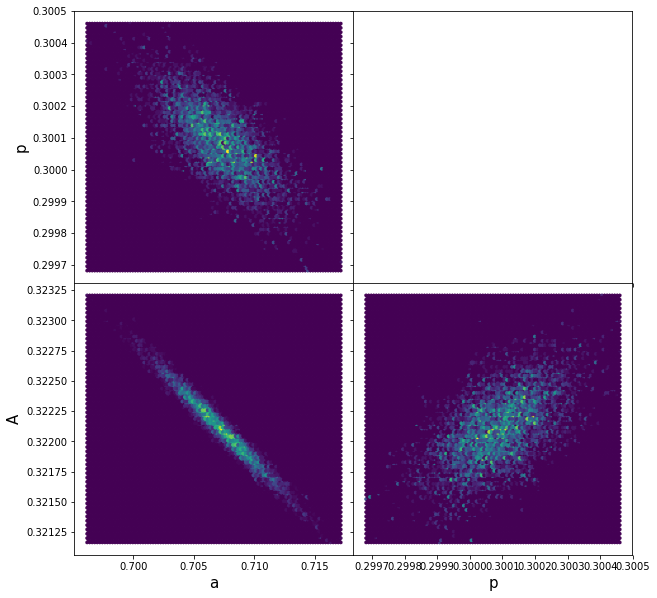

In [109]:
fig, ax = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 10), gridspec_kw={"hspace":0, 'wspace': 0})

flatchain = sampler_hmf.chain[:, 100:, :].reshape((-1, 3))

ax[0, 0].hexbin(flatchain[:, 0], flatchain[:, 1])
ax[1, 0].hexbin(flatchain[:, 0], flatchain[:, 2])
ax[1, 1].hexbin(flatchain[:, 1], flatchain[:, 2])

ax[1, 0].set_xlabel("a", fontsize=15)
ax[1, 0].set_ylabel("A", fontsize=15)
ax[1, 1].set_xlabel("p", fontsize=15)
ax[0, 0].set_ylabel("p", fontsize=15)


Since we collected $dn/d\log_{10}m$ as a derived parameter, we can also plot it:

In [116]:
dndlog10m_samples = sampler_hmf.blobs[100:, :, :].reshape((-1, 40))

We'll make a plot of the posterior distribution of the mass function, as a fraction of the median of the distribution:

In [118]:
percentiles = np.percentile(dndlog10m_samples, q=(16, 50, 84), axis=0)

Text(0.5, 0, 'Mass')

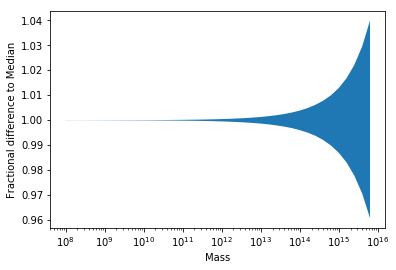

In [128]:
plt.fill_between(fiducial_model.m, percentiles[0]/percentiles[1], percentiles[2]/percentiles[1])
plt.xscale('log')
plt.ylabel("Fractional difference to Median")
plt.xlabel("Mass")
#plt.yscale('log')